In [32]:
!pip install datasets --upgrade

Defaulting to user installation because normal site-packages is not writeable


In [33]:
from datasets import load_dataset


ds = load_dataset("sajjadhadi/disease-diagnosis-dataset") #getting random queries

In [34]:
import re
from datasets import load_dataset
import json

ds = load_dataset("sajjadhadi/disease-diagnosis-dataset")

def clean_text(t):
    # removing prediction lines
    t = re.sub(r"based on these symptoms.*", "", t, flags=re.IGNORECASE)
    # remove phrases
    t = t.replace("Patient reported these symptoms:", "").strip()
    return t

eval_data = []
for record in ds["test"]:  # use test split
    cleaned = clean_text(record["text"])
    disease = record["diagnosis"].strip()
    if cleaned:  # skip empty after cleaning
        eval_data.append({
            "query": cleaned,
            "expected_disease": disease
        })

# sampling a smaller evaluation subset
import random
sampled = random.sample(eval_data, 2000)
with open("evaluation_cleaned.json", "w") as f:
    json.dump(sampled, f, indent=2)

print(f"Saved {len(sampled)} cleaned evaluation samples.")


Saved 2000 cleaned evaluation samples.


In [35]:
with open("medical_dataset.json") as f:
    local_data = json.load(f)
local_diseases = {d['disease'].lower() for d in local_data}

with open("evaluation_cleaned.json") as f:
    eval_data = json.load(f)

filtered = [
    e for e in eval_data
    if e['expected_disease'].lower() in local_diseases
]

print(f"Filtered {len(filtered)} out of {len(eval_data)} compatible cases.") #which are relevant to input datasets
with open("evaluation_filtered.json", "w") as f:
    json.dump(filtered, f, indent=2)


Filtered 70 out of 2000 compatible cases.


In [36]:
with open("evaluation_filtered.json") as f:
    filtered_data = json.load(f)

print(f"Total records: {len(filtered_data)}\n")

# Print first 5 samples
for i, item in enumerate(filtered_data[:5], 1):
    print(f"--- Sample {i} ---")
    print("Query:", item["query"])
    print("Expected disease:", item["expected_disease"])
    print()


Total records: 70

--- Sample 1 ---
Query: depressive or psychotic symptoms ,dizziness ,abnormal involuntary movements ,feeling ill ,nausea and decreased appetite  may indicate.
Expected disease: hypoglycemia

--- Sample 2 ---
Query: vomiting ,nausea ,blindness and disturbance of memory  may indicate.
Expected disease: migraine

--- Sample 3 ---
Query: skin swelling ,skin growth ,irregular appearing scalp ,skin moles ,long menstrual periods ,skin dryness, peeling, scaliness, or roughness and skin rash.
Expected disease: acne

--- Sample 4 ---
Query: skin swelling ,abnormal appearing skin and irregular appearing scalp  may indicate.
Expected disease: acne

--- Sample 5 ---
Query: cough ,vomiting ,headache ,fever ,chills and flu-like syndrome  may indicate.
Expected disease: common cold



In [37]:
import time
from hybrid_rag import HybridDiseaseRAG
from graph_rag import DiseaseGraphRAG
from vector_rag import DiseaseRAGSystem  

def evaluate_model(model, eval_data, top_k=3, show_progress=True):
    """
    evaluating a disease diagnosis model using Top-1 and Top-3 accuracy.
    """
    correct_top1, correct_top3, total = 0, 0, 0
    start = time.time()

    for i, case in enumerate(eval_data, 1):
        query = case["query"]
        expected = case["expected_disease"]

        result = model.diagnose(query, top_k=top_k)
        top_diseases = [d["disease"] for d in result.get("top_diseases", [])]

        if not top_diseases:
            continue

        total += 1
        if top_diseases[0].lower() == expected.lower():
            correct_top1 += 1
        if expected.lower() in [t.lower() for t in top_diseases]:
            correct_top3 += 1

        if show_progress and i % 50 == 0:
            print(f"Processed {i}/{len(eval_data)} cases...")

    end = time.time()
    avg_time = (end - start) / total if total else 0

    return {
        "Top-1 Acc": correct_top1 / total if total else 0,
        "Top-3 Acc": correct_top3 / total if total else 0,
        "Avg Inference Time (s)": avg_time,
        "Samples": total
    }

if __name__ == "__main__":
    with open("evaluation_filtered.json") as f:
        eval_data = json.load(f)

    print(f"Loaded {len(eval_data)} evaluation samples.\n")
    print("Loading models...")

    vector_model = DiseaseRAGSystem("medical_dataset.json")
    graph_model  = DiseaseGraphRAG("medical_dataset.json")
    hybrid_model = HybridDiseaseRAG("medical_dataset.json")

    print("\nEvaluating Vector-based Model...")
    vector_results = evaluate_model(vector_model, eval_data)

    print("\nEvaluating Graph-based Model...")
    graph_results = evaluate_model(graph_model, eval_data)

    print("\nEvaluating Hybrid Model...")
    hybrid_results = evaluate_model(hybrid_model, eval_data)

    # Summary 
    print("\n" + "="*50)
    print("MODEL COMPARISON SUMMARY")
    print("="*50)
    for name, res in zip(
        ["Vector", "Graph", "Hybrid"],
        [vector_results, graph_results, hybrid_results]
    ):
        print(f"\n{name} Model:")
        for k, v in res.items():
            print(f"  {k}: {v:.3f}" if isinstance(v, float) else f"  {k}: {v}")

    #rank models by Top-1 accuracy
    best_model = max(
        [("Vector", vector_results["Top-1 Acc"]),
         ("Graph", graph_results["Top-1 Acc"]),
         ("Hybrid", hybrid_results["Top-1 Acc"])],
        key=lambda x: x[1]
    )
    print(f"\n Done")


Loaded 70 evaluation samples.

Loading models...

Evaluating Vector-based Model...
Processed 50/70 cases...

Evaluating Graph-based Model...
Processed 50/70 cases...

Evaluating Hybrid Model...
Processed 50/70 cases...

MODEL COMPARISON SUMMARY

Vector Model:
  Top-1 Acc: 0.200
  Top-3 Acc: 0.457
  Avg Inference Time (s): 0.136
  Samples: 70

Graph Model:
  Top-1 Acc: 0.171
  Top-3 Acc: 0.443
  Avg Inference Time (s): 0.196
  Samples: 70

Hybrid Model:
  Top-1 Acc: 0.171
  Top-3 Acc: 0.457
  Avg Inference Time (s): 0.317
  Samples: 70

 Done


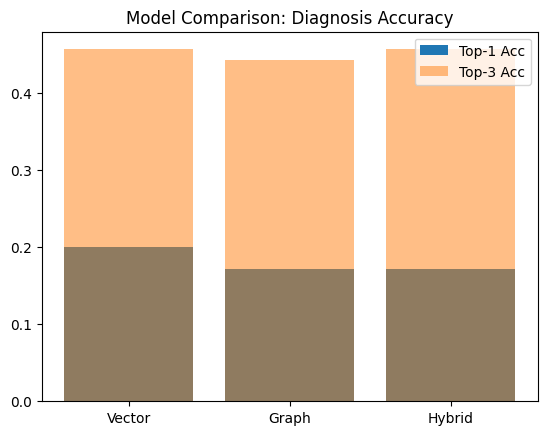

In [38]:
import matplotlib.pyplot as plt

models = ["Vector", "Graph", "Hybrid"]
top1 = [vector_results["Top-1 Acc"], graph_results["Top-1 Acc"], hybrid_results["Top-1 Acc"]]
top3 = [vector_results["Top-3 Acc"], graph_results["Top-3 Acc"], hybrid_results["Top-3 Acc"]]

plt.bar(models, top1, label="Top-1 Acc")
plt.bar(models, top3, alpha=0.5, label="Top-3 Acc")
plt.title("Model Comparison: Diagnosis Accuracy")
plt.legend()
plt.show()
